<a href="https://colab.research.google.com/github/Maagnitude/CRC_slides_models/blob/main/CRC_slides_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία** στο μάθημα **Μηχανική Μάθηση και Εφαρμογές**

# **Τμήμα Πληροφορικής και Τηλεματικής - Χαροκόπειο Πανεπιστήμιο**

# **Καζάζης Γεώργιος - it214124**

Στην παρούσα εργασία θα αναπτύξουμε **μοντέλα Συνελικτικών Νευρωνικών Δικτύων**, για να κατηγοριοποιήσουμε όσο πιο σωστά γίνεται τις 7180 εικόνες μικροσκοπίου, στις 9 κλάσεις που έχουμε.

**Αρχίζοντας...**

# **Βιβλιοθήκες**
Κάνουμε import τα απαραίτητα **modules**. 
*   Την **pandas** και την **numpy** για την διαχείρηση των δεδομένων μας.

*  Την **matplotlib.pyplot** και την **seaborn** για την οπτικοποίηση των δεδομένων μας. **Ιστογράμματα**, **boxplots** κλπ.

*  Την **missingno** ώστε να οπτικοποιήσουμε το αν υπάρχουν ελλιπείς εγγραφές.

*   Από την **sklearn** κάνουμε import:
      *   Την **linear_model** για να εκπαιδεύσουμε το **Logistic Regression model**.
      *   Την **neural_network** για να υλοποιήσουμε και να εκπαιδεύσουμε ΤΝΔ.
      *  Την **StardardScaler** και την **train_test_split** για το **Preprocessing** κομμάτι. Συγκεκριμένα για την τυποποίηση των δεδομένων και για να χωρίσουμε τα δεδομένα μας σε **test data** και **train data**.
      *  Την **metrics** για τις μετρικές που θα χρησιμοποιήσουμε, όπως η **confusion_matrix**.
      *  Την **RandomForestClassifier** για να εκπαιδεύσουμε ένα Random Forest model.
*  Το **tensorflow**, και από αυτό, τα **keras** και **layers** για την ανάπτυξη νευρωνικών δικτύων.

*  Τέλος, κάνουμε import τα **warnings** και τα φιλτράρουμε, ώστε να μην εμφανίζονται.


In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.datasets
from keras.callbacks import EarlyStopping
from keras.layers import Rescaling
from keras.layers import MaxPooling2D

from keras.applications.efficientnet import EfficientNetB0

## **drive mount και μεταφόρτωση των εικόνων**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

# **Υλοποίηση συνάρτησης για την δημιουργία των datasets**
Περνάμε τα αρχεία του φακέλου **data_dir** στην μεταβλητή **all_ds** και ύστερα τα χωρίζουμε σε **training**, **validation** και **test sets**. Το πετυχαίνουμε με την χρήση των συναρτήσεων **next** και **skip**, όπου παίρνουμε τον αριθμό των αρχείων που αντιστοιχεί στο **devel_ds** (**next**), ύστερα τα κάνουμε **skip**, ώστε να πάρουμε τα επόμενα για το **train_ds** κτλ.

Σχετικά με τις παραμέτρους: 
* **data_dir** είναι ο φάκελος που βρίσκονται τα αρχεία.
* **labels='inferred'** για να παράξει τα labels από τους υποφακέλους.
* **label_moded='int'** που συμαίνει ότι τα labels είναι κωδικοποιημένα ως integers.
* **class_names**=None για να χρησιμοποιηθεί αλφαριθμητικη σειρά, μιας και δεν μας νοιάζει.
* **color_mode='rgb'** για να έχουν 3 κανάλια οι εικόνες.
* **batch_size** βάζουμε το batch size που μας δίνει η εκφώνηση. Πόσες εικόνες θα πάρει μαζί. Το default θα ήταν 32.
* **image_size** βάζουμε το size που μας δίνει η εκφώνηση. Αν βάλουμε άλλο αριθμό απ αυτόν που είναι η εικόνες, γίνεται resize.
* **shuffle=True** που είναι και η default τιμή, απλά το βάζουμε να φαίνεται. Αν ήταν False θα έκανε sort τα δεδομένα σε αλφαριθμητική σειρά.
* **seed=123** ???

In [129]:
def load_dataset(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):

  # Βάζουμε τα όλα δεδομένα στην μεταβλητή all_ds
  all_ds = keras.utils.image_dataset_from_directory(data_dir, labels='inferred', label_mode='int', class_names=None, 
                              color_mode='rgb', batch_size=batch_size, image_size=img_size, shuffle=True, seed=123)

  # Χωρίζουμε τα δεδομένα μας σε training, validation και test sets
  # Παίρνουμε το σύνολο των δειγμάτων
  num_samples = len(all_ds)
  
  # Παίρνουμε το μέγεθος του κάθε set βάσει του ποσοστού που γνωρίζουμε
  train_size = int(train_pct * num_samples)
  val_size = int(val_pct * num_samples)
  test_size = int(test_pct * num_samples)
  devel_size = num_samples - train_size - val_size - test_size

  # Ανάλογα με το size του κάθε set, το γεμίζουμε με τα δεδομένα της all_ds
  devel_ds = all_ds.take(devel_size)
  train_ds = all_ds.skip(devel_size).take(train_size)
  val_ds = all_ds.skip(devel_size + train_size).take(val_size)
  test_ds = all_ds.skip(devel_size + train_size + val_size).take(test_size)

  # Παίρνουμε τις κατηγορίες των δεδομένων
  classes = all_ds.class_names

  return devel_ds, train_ds, val_ds, test_ds, classes

In [130]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.


## **Για να δούμε τις πρώτες 9 εικόνες του train_ds**

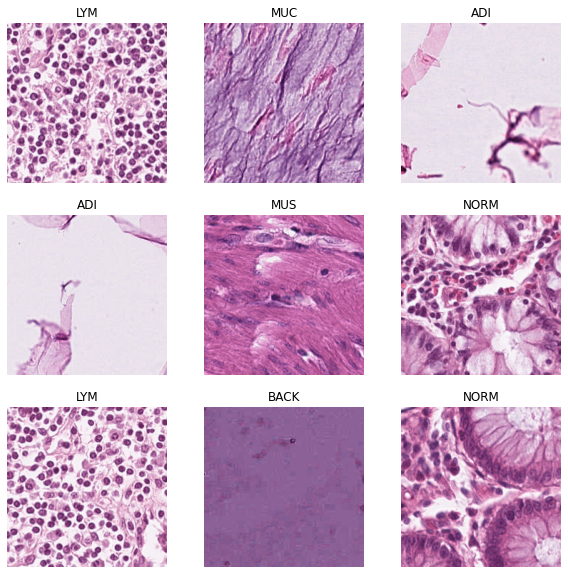

In [170]:
plt.figure(figsize=(10, 10))
for images, labels in devel_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [125]:
images_ds = tf.data.Dataset.list_files(data_dir+"/*/*", shuffle=False)

for image in images_ds.take(1):
  print(image.numpy())

b'/content/CRC_slides/ADI/ADI-TCGA-AAICEQFN.png'


In [141]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [144]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (64, 224, 224, 3)
Label:  (64,)


In [11]:
num_classes= len(classes)

## **Παρακάτω οπτικοποιούμε τον αριθμό των αρχείων κάθε κατηγορίας στο σύνολο ανάπτυξης**.

Παρατηρούμε ότι οι κατηγορίες 2, 5 και 7, υπάρχουν σε μικρή ποσότητα στα datasets, και οι 1, 4 και 8, υπάρχουν σε αρκετά μεγάλη ποσότητα. 

Οπότε έχουν ένα όχι και τόσο ισορροπημένο dataset, το οποίο ίσως κάνει το μοντέλο μας να υποεκπαιδευτεί, μαθαίνοντας καλά στις 3 απ τις 9 κατηγορίες, και όχι και τόσο καλά στις άλλες 3 απ τις 9.

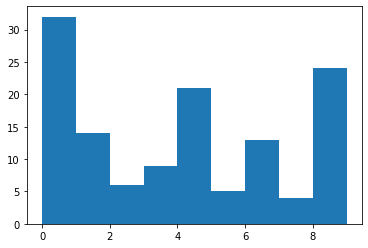

In [6]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

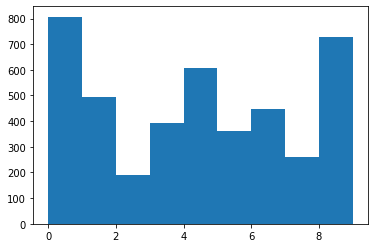

In [7]:
y = np.concatenate([y for x, y in train_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

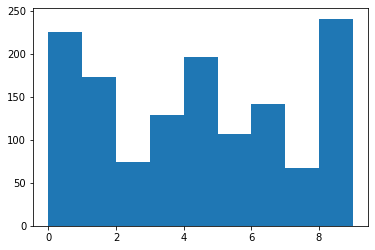

In [8]:
y = np.concatenate([y for x, y in test_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

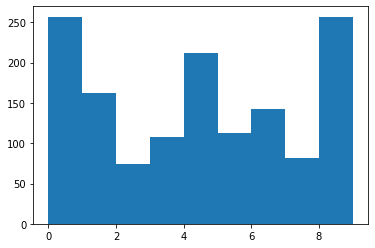

In [9]:
y = np.concatenate([y for x, y in val_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

# **Υλοποίηση συνάρτησης για την δημιουργία συνελικτικού νευρωνικού δικτύου**.

Αρχικά περνάμε στην είσοδο την εικόνα 224x224 pixel x3 για το rgb.

Στο **πρώτο layer** κάνουμε rescaling τις τιμές των εικόνων (pixel values) από **[0, 255]** σε **[0, 1]**.

Στο επόμενο έχουμε ένα συνελικτικό επίπεδο **8 φίλτρων **3x3 με **padding='same'** για να έχουμε έξοδο ίση με την είσοδο, και activation function **ReLU**.

Ύστερα έχουμε ένα επίπεδο **MaxPooling** με βήμα 2.

Επαναλαμβάνουμε τα δύο παραπάνω επίπεδα, με την διαφορά ότι το συνελικτικό τώρα έχει **16 φίλτρα**.

Ένα επίπεδο **Flatten()** για να μετατρέψουμε τις τιμές κάθε εικόνας σε 1 διάσταση.

Τέλος, έχουμε ένα πλήρως συνδεδεμένο επίπεδο **32 νευρώνων** με activation function **ReLU**, κι ένα επίπεδο εξόδου για τις **9** (num_classes) **κατηγορίες** που θέλουμε να προβλέψουμε, με activation function **softmax** για να πάρουμε τιμές που αθροίζουν στο 1 (για το πόσο σίγουρο είναι το μοντέλο για κάθε κατηγορία).

In [147]:
def cnn1(num_classes):

  #
  model = keras.Sequential([
      keras.Input(shape=(224, 224, 3)),
      layers.Rescaling(1./255),
      layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  return model

## **Εκπαίδευση μοντέλου και εκτίμηση.**
Καλούμε την παραπάνω συνάρτηση και μας επιστρέφει το μοντέλο μας.

Το κάνουμε compile με Adam optimizer, βάζοντας τις επιθυμητές τιμές στις παραμέτρους. **Ρυθμό εκμάθησης=0.001**, **ρυθμό ενημέρωσης πρώτης ροπής=0.9 **και **ρυθμό ενημέρωσης δεύτερης ροπής=0.99**. Για loss επέλεξα την **Sparce categorical crossentropy**, για να μην κάνω one-hot encoding στα labels.

Ρυθμίζουμε την εκπαίδευση του μοντέλου να σταματήσει πρόωρα αν δεν παρουσιαστεί μείωση της απώλειας στο σύνολο επικύρωσης για 5 εποχές, με την κλήση της **EarlyStopping** δίνοντας της ως παράμετρο την τιμή που πρέπει να παρακολουθεί και τις εποχές πέραν των οποιών θα πρέπει να σταματήσει η εκπαίδευση.

Τέλος, εκπαιδεύουμε το μοντέλο και το εξετάζουμε στο σύνολο επικύρωσης.

In [169]:
model = cnn1(num_classes)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=20)
score = model.evaluate(val_ds)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 50176)           

## **Αποτελέσματα**
Το μοντέλο εκπαιδεύτηκε για **1 ώρα και 3 λεπτά**, και για τις **20 εποχές** μιας και δεν χρειάστηκε να τερματιστεί πρόωρα, και η εξέταση στο σύνολο επικύρωσης έφερε τα αποτελέσματα **loss: 0.8368** και **accuracy: 0.7578**

In [149]:
def confusion_matrix(model, test_ds):
    y_test = []
    y_pred = []
    for x_1, y_1 in test_ds:
        y_pred_1 = model.predict(x_1)
        y_test.append(y_1)
        y_pred.append(y_pred_1)
        y_true = np.concatenate(y_test)
        y_p = np.concatenate(y_pred)
        y_hat = tf.argmax(y_p, axis=1)
        cm = tf.math.confusion_matrix(y_true, y_hat)
    return cm, y_hat

In [159]:
def heat_confmatrix (cm):
  
  labels = classes

  # Δίνουμε τα labels στον πίνακα
  cm_plt = pd.DataFrame(cm, index = labels, columns = labels)
  
  plt.subplots(figsize=(9, 7))
  
  ax = sns.heatmap(cm_plt, cmap='viridis', annot=True, annot_kws={'size':20}, fmt="d")

  ax.xaxis.tick_top()
  ax.set_title("Confusion Matrix\n")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

In [171]:
cm, y_hat = confusion_matrix(model, test_ds)

1/1 [==============================] - 0s 208ms/step


## **Confusion Matrix**
Παρατηρούμε ότι για την κατηγορία STR δεν έχει εκπαιδευτεί σωστά. 
Το μοντέλο προβλέπει MUS ενώ είναι STR σε 42 δείγματα. Ενώ προβλέπει STR και πέφτει μέσα μόνο σε 8 δείγματα.

Επίσης όταν προβλέπει DEB, πέφτει μέσα σε 67 δείγματα, και σε 45 είναι λάθος γιατί η πραγματική εικόνα αφορούσε την κατηγορία TUM.

Ακόμα και στην MUS που πέφτει μέσα σε 109 δείγματα, προβλέπει 92 δείγματα λάθος, τα οποία στην πραγματικότητα ανήκουν στην κατηγορία TUM.

Οι κατηγορίες που παρατηρούμε το πρόβλημα, είναι οι ίδιες με αυτές που παρατηρήσαμε ότι υπάρχουν σε μικρή ποσότητα σε όλα τα sets, που σημαίνει ότι πολύ πιθανόν το μοντέλο **υποεκπαιδεύτηκε**.

Τέλος, στις κατηγορίες ADI, MUC και TUM, τα πήγε πολύ καλά, μιας και όπως είδαμε και πιο πάνω, υπάρχουν πολλές εικόνες αυτών των κατηγοριών στο dataset, με αποτέλεσμα το μοντέλο να τις μάθει πολύ καλύτερα απ' τις άλλες.

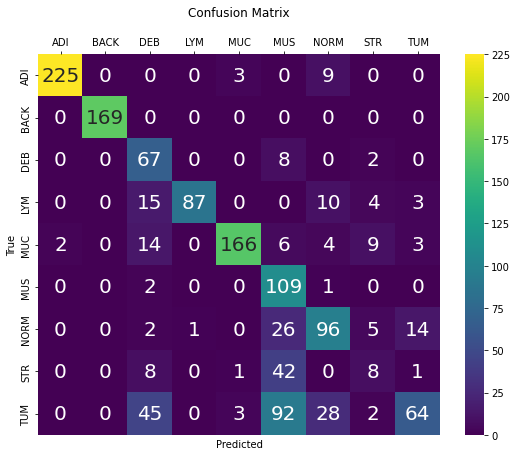

In [172]:
heat_confmatrix(cm.numpy())

# **4. Deeper CNN**

In [173]:
def cnn2(num_classes):

  #
  model = keras.Sequential([
      keras.Input(shape=(224, 224, 3)),
      layers.Rescaling(1./255),
      layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),      
      layers.MaxPooling2D(pool_size=(4, 4)),
      layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),      
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),  
      layers.MaxPooling2D(pool_size=(2, 2)),   
      layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),  
      layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),  
      layers.MaxPooling2D(pool_size=(2, 2)),  
      layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),               
      layers.MaxPooling2D(pool_size=(2, 2)),  
      layers.Flatten(),
      layers.Dense(1024, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  return model

In [ ]:
model2 = cnn2(num_classes)

model2.summary()

model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model2.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=20)
score = model2.evaluate(val_ds)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_39 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 56, 56, 64)        36928     
                                                     

In [167]:
model3 = keras.applications.efficientnet.EfficientNetB0()

# model3.summary()

model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model3.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=1)
score = model3.evaluate(val_ds)

22/22 [==============================] - 111s 5s/step - loss: 0.5767 - accuracy: 0.9112
